<a href="https://colab.research.google.com/github/FangTzuLiang/Image-Process/blob/main/HW3_0921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unet 貓狗辨識

In [ ]:
!unzip -q '/content/Dog Segmentation.zip' # -q代表不顯示解壓縮過程

replace Dog Segmentation/Images/dog.8788.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# 簡單的Unet模型示例（使用Keras）
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

In [ ]:
# 數據預處理，讀取圖像和標籤數據，然後將它們轉換為NumPy數組，最後將數據分為訓練集和測試集

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

# 設定資料路徑
data_dir = '/content/Dog Segmentation'
image_dir = os.path.join(data_dir, 'Images')
label_dir = os.path.join(data_dir, 'Labels')

# 讀取圖像檔案名稱和標籤檔案名稱
image_files = os.listdir(image_dir)
label_files = os.listdir(label_dir)

# 確保圖像和標籤對應的順序相符
image_files.sort()
label_files.sort()

# 初始化空的列表來存儲圖像和標籤數據
images = []
labels = []

# 讀取圖像和標籤並轉換為NumPy數組
for image_file, label_file in zip(image_files, label_files):
    # 創建圖像和標籤檔案的完整路徑
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, label_file)

    # 讀取圖像和標籤並調整大小為256x256像素，同時轉換為灰度圖像
    image = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), (256, 256))
    label = cv2.resize(cv2.imread(label_path, cv2.IMREAD_GRAYSCALE), (256, 256))

    # 將圖像轉換為(128, 128, 1)形狀
    # 將圖像和標籤轉換為形狀為(256, 256, 1)的NumPy數組
    image = np.expand_dims(image, axis=-1)# 升維
    label = np.expand_dims(label, axis=-1)
    images.append(image)
    labels.append(label)

# 將圖像和標籤列表轉換為NumPy數組，並將像素值正規化為0到1之間
X = np.array(images)/255.0
y = np.array(labels)/255.0

# 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 定義Unet模型

from keras.layers import BatchNormalization

def unet_model(input_shape=(256, 256, 1)):
    # 定義模型的輸入層，輸入形狀為 (256, 256, 1)
    inputs = Input(input_shape)

    # encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)# 第一個卷積層
    conv1 = BatchNormalization()(conv1)# 對第一個卷積層的輸出進行批量標準化
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)# 第二個卷積層
    conv1 = BatchNormalization()(conv1)# 對第二個卷積層的輸出進行批量標準化，標準化可提高訓練的穩定性和速度
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)# 第一個池化層

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv13 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv13 = BatchNormalization()(conv13)
    conv13 = Conv2D(512, 3, activation='relu', padding='same')(conv13)
    conv13 = BatchNormalization()(conv13)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv13)

    conv6 = Conv2D(1024, 3, activation='relu', padding='same',dilation_rate=1)(pool4)
    conv6 = BatchNormalization()(conv6)
    conv8 = Conv2D(1024, 3, activation='relu', padding='same',dilation_rate=3)(pool4)
    conv8 = BatchNormalization()(conv8)
    conv9 = Conv2D(1024, 3, activation='relu', padding='same',dilation_rate=5)(pool4)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1024, 3, activation='relu', padding='same',dilation_rate=7)(pool4)
    conv10 = BatchNormalization()(conv10)
    merge4 = Concatenate(axis=3)([conv6, conv8])
    merge5 = Concatenate(axis=3)([merge4, conv9])
    merge6 = Concatenate(axis=3)([merge5, conv10])

    conv11 = Conv2D(2048, 3, activation='relu', padding='same')(merge6)
    conv11 = Conv2D(2048, 3, activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)
    conv12 = Conv2D(1024, 3, activation='relu', padding='same')(conv11)
    conv12 = Conv2D(1024, 3, activation='relu', padding='same')(conv12)
    conv12 = BatchNormalization()(conv12)

    # decoder
    up4 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv12))# 第一個上採樣層
    merge7 = Concatenate(axis=3)([conv13, up4])# 連接解碼器和編碼器的特徵圖
    conv14 = Conv2D(512, 3, activation='relu', padding='same')(merge7)# 卷積層
    conv14 = BatchNormalization()(conv14)# 批量標準化
    conv14 = Conv2D(512, 3, activation='relu', padding='same')(conv14)# 卷積層
    conv14 = BatchNormalization()(conv14)# 批量標準化

    up3 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv14))
    merge3 = Concatenate(axis=3)([conv3, up3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up1 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge1 = Concatenate(axis=3)([conv2, up1])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up2 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge2 = Concatenate(axis=3)([conv1, up2])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # 最後一個卷積層，輸出通道數為1
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs, output)# 創建模型，指定輸入和輸出
    return model

model = unet_model(input_shape=(256, 256, 1))

In [13]:
from keras.callbacks import ModelCheckpoint

# 創建ModelCheckpoint回調（callback）實例，使得模型在訓練過程中能夠自動保存最佳的權重
# 當模型的驗證損失達到最小值時，ModelCheckpoint將自動保存模型權重到指定的文件（在這裡是 'best_model.h5'），在訓練結束後，可以載入這些最佳權重，以獲得性能最佳的模型
model_checkpoint = ModelCheckpoint(
    'best_model.h5', # 保存模型權重的文件名
    monitor='val_loss', # 監控test data上的loss
    save_best_only=True, # 僅保存性能最好的模型權重
    mode='min', # 模型性能的評估指標是最小化tets data上的loss
    verbose=1 # 印出提示信息
)

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型並加入ModelCheckpoint回調
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint]  # 將ModelCheckpoint回調添加到訓練過程
)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.5431  
Epoch 1: val_loss improved from inf to 133.95197, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1777s 99s/step - loss: 0.7733 - accuracy: 0.5431 - val_loss: 133.9520 - val_accuracy: 0.5231
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.6208 - accuracy: 0.6433  
Epoch 2: val_loss improved from 133.95197 to 20.82432, saving model to best_model.h5
18/18 [==============================] - 1788s 100s/step - loss: 0.6208 - accuracy: 0.6433 - val_loss: 20.8243 - val_accuracy: 0.4455
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7123  
Epoch 3: val_loss did not improve from 20.82432
18/18 [==============================] - 1754s 97s/step - loss: 0.5605 - accuracy: 0.7123 - val_loss: 36.5591 - val_accuracy: 0.4819
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.7256  
Epoch 4: val_loss did not improve from 20.82432
18/18 [==============================] - 1727s 96s/step - loss: 0.5358 - accuracy: 0.7256 - val_loss: 31.0627 - val_accuracy: 0.55

In [16]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 256, 256, 64)         256       ['conv2d_29[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_30 (Conv2D)          (None, 256, 256, 64)         36928     ['batch_normalization_22

In [26]:
# 使用Grad-CAM技術可視化深度學習模型中的卷積層特徵對於特定目標類別（這裡是狗）的關注程度

import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# 選擇要可視化的圖像
sample_image = X_test[16]
# 將圖像轉換為模型的輸入形狀（256x256x1）
input_image = cv2.resize(sample_image, (256, 256))# 調整圖像大小為256x256像素
input_image = input_image[np.newaxis, ...]# 添加批次維度，將圖像轉換為模型所需的形狀

# 取得模型的中間層特徵圖
activation_layer = 'conv2d_48'
activation_model = Model(inputs=model.input, outputs=model.get_layer(activation_layer).output)

# 通過模型預測獲得中間層特徵圖
activations = activation_model.predict(input_image)

# 使用模型預測圖像的類別
predictions = model.predict(input_image)

# 取得目標類別（這裡是二元分類，取1表示狗）
target_class = 1

# 計算Grad-CAM
grad_model = Model(
    [model.inputs], [model.get_layer(activation_layer).output, model.output]
)

# 使用GradientTape計算梯度
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_image)# 獲得中間層輸出和模型輸出
    loss = predictions[:, target_class]# 計算目標類別的loss

output_grads = tape.gradient(loss, conv_outputs)[0]# 計算loss相對於中間層輸出的梯度

weights = np.mean(output_grads, axis=(0, 1))# 計算權重
cam = np.dot(activations[0], weights)# 使用權重對特徵圖進行加權總和

# 使用ReLU函數進行閾值處理，保留正值
# 閾值處理可以用於增強圖像的特定特徵或去除噪聲
cam = np.maximum(cam, 0)

# 正規化，將Grad-CAM正規化到範圍[0, 1]
cam = cam / np.max(cam)

# 調整 Grad-CAM 的大小，以便與原始圖像相符
cam = cv2.resize(cam, (256, 256))

1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 1s 631ms/step


Text(0.5, 1.0, 'Grad-CAM')

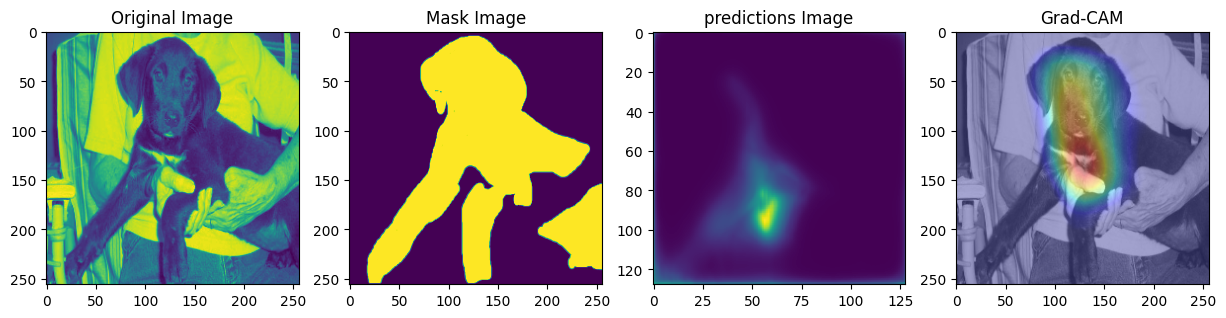

In [27]:
# 繪製原始圖像、標籤圖像、模型的預測結果圖像、Grad-CAM可視化結果

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))# 創建一個畫布，設置大小為15x5

# 第一個子圖:原始圖像
plt.subplot(1, 4, 1)# 創建一個1x4的子圖佈局，選擇第1個子圖
plt.imshow(X_test[16])
plt.title('Original Image')

# 第二個子圖:標籤圖像
plt.subplot(1, 4, 2)# 選擇第2個子圖
plt.imshow(y_test[16])
plt.title('Mask Image')

# 選擇要可視化的圖像
sample_image = X_test[16]

# 將圖像轉換為模型的輸入形狀（128x128x3）
input_image = cv2.resize(sample_image, (128, 128))
input_image = input_image[np.newaxis, ...]

predictions = model.predict(input_image)# 使用模型預測圖像

# 第三個子圖:模型的預測結果圖像
plt.subplot(1, 4, 3)# 選擇第3個子圖
plt.imshow(predictions[0])
plt.title('predictions Image')

# 第四個子圖:Grad-CAM可視化結果
plt.subplot(1, 4, 4)# 選擇第4個子圖
plt.imshow(cam, cmap='jet', alpha=0.7)# 'jet'是一種顏色map
plt.imshow(sample_image, cmap='gray', alpha=0.5)# 顯示原始圖像
plt.title('Grad-CAM')

LSTM溫度預測

Mounted at /content/drive
Epoch 1/10
500/500 [==============================] - 4s 5ms/step - loss: 0.0406
Epoch 2/10
500/500 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 3/10
500/500 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 9.8334e-04
Epoch 5/10
500/500 [==============================] - 2s 5ms/step - loss: 8.7280e-04
Epoch 6/10
500/500 [==============================] - 2s 5ms/step - loss: 8.2799e-04
Epoch 7/10
500/500 [==============================] - 2s 5ms/step - loss: 8.0351e-04
Epoch 8/10
500/500 [==============================] - 2s 4ms/step - loss: 7.4077e-04
Epoch 9/10
500/500 [==============================] - 3s 5ms/step - loss: 6.9179e-04
Epoch 10/10
2628/2628 [==============================] - 4s 2ms/step


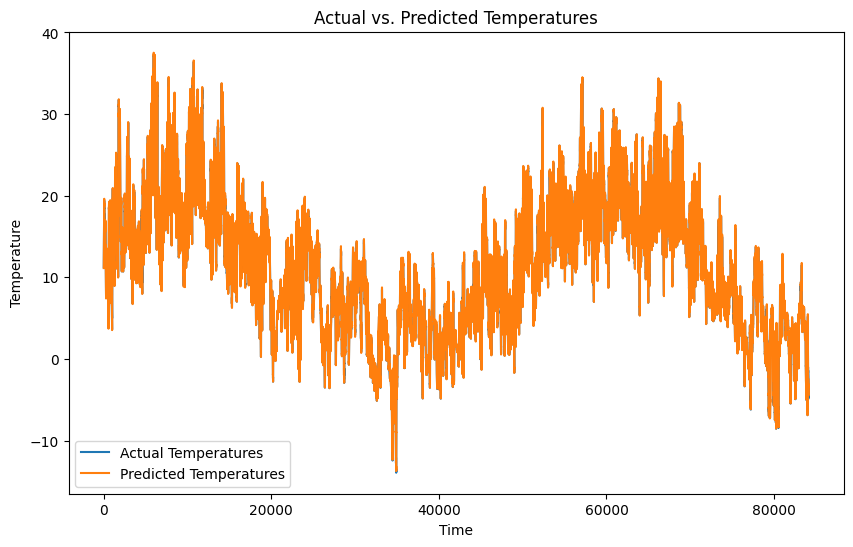

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 從雲端硬碟載入數據集
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/jena_climate_2009_2016.csv'
data = pd.read_csv(file_path)

# 從數據中提取溫度數據，並轉換為NumPy數組
temperature = data['T (degC)'].values

# 資料前處理
scaler = StandardScaler()# 創建一個StandardScaler實例，用於正規化數據
temperature_scaled = scaler.fit_transform(temperature.reshape(-1, 1))# 使用標準化器對溫度數據進行正規化

# 創建時間序列數據
sequence_length = 10# 定義時間序列的長度
X = []# 用於存儲輸入序列的列表
y = []# 用於存儲目標值的列表

for i in range(len(temperature_scaled) - sequence_length):
    X.append(temperature_scaled[i:i + sequence_length])# 創建長度為sequence_length的輸入序列
    y.append(temperature_scaled[i + sequence_length])# 創建對應的目標值
X = np.array(X)
y = np.array(y)

# 分割數據集為訓練集和測試集
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 建立LSTM模型
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(sequence_length, 1)))# 添加LSTM層，32個單元，relu激活函數
model.add(Dense(1))# 添加一個全連接層，用於回歸任務
model.compile(optimizer='adam', loss='mean_squared_error')# 編譯模型

# 訓練模型
model.fit(X_train, y_train, steps_per_epoch=500, epochs=10, batch_size=128)

# 進行溫度預測
predicted_temperatures_scaled = model.predict(X_test)

# 將預測結果轉換回原始尺度
predicted_temperatures = scaler.inverse_transform(predicted_temperatures_scaled)# 使用逆轉換還原預測值
y_test_original = scaler.inverse_transform(y_test)# 使用逆轉換還原預測值

# 繪製實際溫度和預測溫度的比較圖
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Temperatures')
plt.plot(predicted_temperatures, label='Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures')
plt.legend()
plt.show()